In [1]:
from pylab import * 
import numpy as np
import matplotlib as mtp
import matplotlib.pyplot as plt
from sklearn import *
from scipy import interpolate

In [2]:
#Datenimport Erste Probe
#Faraday1
data1 = genfromtxt(fname="../Erste Probe/faraday1/all_data.txt", delimiter="")
field1 = data1[:,0]
voltage1 = data1[:,1]
std1 = data1[:,2]
direction1 = data1[:,3]
loop1 = data1[:,4]  

#faradaydiodecalibration
calib1 = genfromtxt(fname="../Erste Probe/calibfara/diode_calibration.txt",delimiter="")
polangle1 = calib1[:,0]
diodevoltage1 = calib1[:,1]
diodestd1 = calib1[:,2]

#kerr1
data2 = genfromtxt(fname="../Erste Probe/kerr-messung1/all_data.txt", delimiter="")
fieldtwo = data2[:,0]
voltage2 = data2[:,1]
std2 = data2[:,2]
direction2 = data2[:,3]
loop2 = data2[:,4]

#kerr2
data3 = genfromtxt(fname="../Erste Probe/kerr-messung2/all_data.txt", delimiter="")
field3 = data3[:,0]
voltage3 = data3[:,1]
std3 = data3[:,2]
direction3 = data3[:,3]
loop3 = data3[:,4] 

#kerrdiodecalibration
calib2 = genfromtxt(fname="../Erste Probe/calibrationkerrmethod/diode_calibration.txt",delimiter="")
polangle2 = calib2[:,0]
diodevoltage2 = calib2[:,1]
diodestd2 = calib2[:,2]


#Datenimport zweite Probe
#Faraday1
data4 = genfromtxt(fname="../Zweite Probe/faraday/all_data.txt", delimiter="")
field4 = data4[:,0]
voltage4 = data4[:,1]
std4 = data4[:,2]
direction4 = data4[:,3]
loop4 = data4[:,4]  

#faradaydiodecalibration
calib3 = genfromtxt(fname="../Zweite Probe/faraday/diode_calibration.txt",delimiter="")
polangle3 = calib3[:,0]
diodevoltage3 = calib3[:,1]
diodestd3 = calib3[:,2]

In [3]:
def calibratelinearfit(x,y,weight,n, k):
    """Manuelles Fitting von Wert n bis k"""
    reg = linear_model.LinearRegression()
    xres = x[n:k].reshape(-1,1)
    reg.fit(xres,y[n:k], sample_weight=1/weight[n:k])
    m = reg.coef_
    b = reg.intercept_
    rscore = reg.score(xres, y[n:k])

    #Plot erstellen, um zu sehen ab wann nicht-lineare Verlauf beginnt
    plt.figure(figsize=(12,8))
    plt.legend(loc=0)
    plt.plot(xres, y[n:k])
    plt.plot(xres, m*xres+b)
    plt.xlabel(r"B$_\mathrm{extern}$-Feld (mT)")
    plt.ylabel(r"Spannung Diode $U$(V)") 
    print(rscore,k)

In [4]:
def newfluxcalc(field,voltage,std,direction,loop,polangle,diodevoltage,diodestd,n,k, fname):
    """Diese Funktion beinhaltet 4 Schritte. 1.Linearen Fit entfernen. 2.Werte um x-Achse mitteln. 3.Kalibration (U in °)
    4. Wert in °/Mikrometer"""
    
    #Linearen Fit rausrechnen, mit den oben manuell bestimmten Werten
    reg = linear_model.LinearRegression()
    xres = field[n:k].reshape(-1,1)
    reg.fit(xres,voltage[n:k],sample_weight=1/std[n:k])
    m = reg.coef_
    b = reg.intercept_
    newy = voltage-(m*field+b)

    #Werte um die x-Achse mitteln ohne fehlerhafte Werte am Anfang zu betrachten
    midvalue = np.mean(newy[n:]) 
    newval = newy-midvalue

    #Kalibrationskurve berechnen und Umrechnung V->°
    reg1 = linear_model.LinearRegression()
    calib = diodevoltage.reshape(-1,1)
    reg1.fit(calib,polangle,sample_weight=1/diodestd)
    m1 = reg1.coef_
    b1 = reg1.intercept_
    ypol = m1*newval+b1

    #Vordefintionen für den Plot
    select_up = direction > 0
    select_down = direction <= 0 
    
    field_up_1 = field[(select_up) & (loop == 1)]
    field_down_1 = field[(select_down) & (loop == 1)]
    voltage_up_1 = ypol[(select_up) & (loop == 1)]
    voltage_down_1 = ypol[(select_down) & (loop == 1)]
    std_up_1 = std[(select_up) & (loop == 1)]
    std_down_1 = std[(select_down) & (loop == 1)]

    field_up_2 = field[(select_up) & (loop == 2)]
    field_down_2 = field[(select_down) & (loop == 2)]
    voltage_up_2 = ypol[(select_up) & (loop == 2)]
    voltage_down_2 = ypol[(select_down) & (loop == 2)]
    std_up_2 = std[(select_up) & (loop == 2)]
    std_down_2 = std[(select_down) & (loop == 2)]
    
    #Bei 2 Loops Werte mitteln
    if (len(field_up_1)==len(field_up_2)):
        field_up_mean = (field_up_1+field_up_2)/2
        field_down_mean = (field_down_1+field_down_2)/2
        voltage_up_mean = (voltage_up_1+voltage_up_2)/2
        voltage_down_mean = (voltage_down_1+voltage_down_2)/2
        yerrup = (((std_up_1)+(std_up_2))/2)*m1/10
        yerrdown = (((std_down_1)+(std_down_2))/2)*m1/10
    else:
        field_up_mean = (field_up_1)
        field_down_mean = field_down_1
        voltage_up_mean = voltage_up_1
        voltage_down_mean = voltage_down_1
        yerrup= m1*std_up_1/10
        yerrdown = m1*std_down_1/10


    #Hier wird durch die Dicke der Probe geteilt also Umrechnung in °/Mikrometer
    #Mittelwert oberer Teil der Sättigung
    meandown1 = np.mean(voltage_up_1[n:k])
    meanup1 = np.mean(voltage_up_1[-k:-n])

    #Mittelwert unterer Teil der Sättigung
    meandown2 = np.mean(voltage_down_1[-k:-n])
    meanup2 = np.mean(voltage_down_1[n:k])

    uppervalue = (meandown1+meandown2)/2
    lowervalue = (meanup1+meanup2)/2

    rotation = lowervalue - uppervalue
    yfinal = rotation/0.133                         #Für die Nickel-Probe muss hier durch 0.020 geteilt werden
    print("Rotation je Mikrometer",yfinal,"Winkeldrehung",rotation)

    plt.figure()
    plt.errorbar(field_up_mean,voltage_up_mean, yerr = yerrup, label = r"Mittelwerte B$\uparrow$")
    plt.errorbar(field_down_mean,voltage_down_mean, yerr = yerrdown, label = r"Mittelwerte B$\downarrow$")
    plt.legend(loc = 0)
    plt.xlabel(r"B$_\mathrm{extern}$-Feld (mT)")
    plt.ylabel(r"Polarisationswinkel $\theta$(°)")
    plt.savefig(fname)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9968706660306702 60


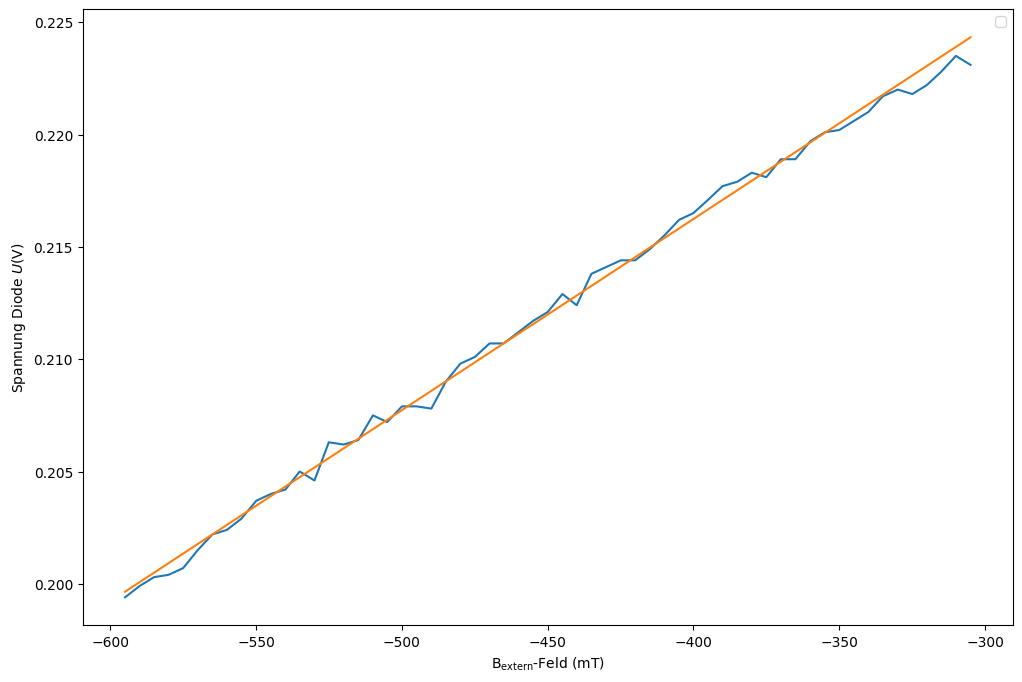

In [5]:
calibratelinearfit(field1, voltage1,std1, 1,60)

Rotation je Mikrometer -21.990586343086797 Winkeldrehung -2.924747983630544


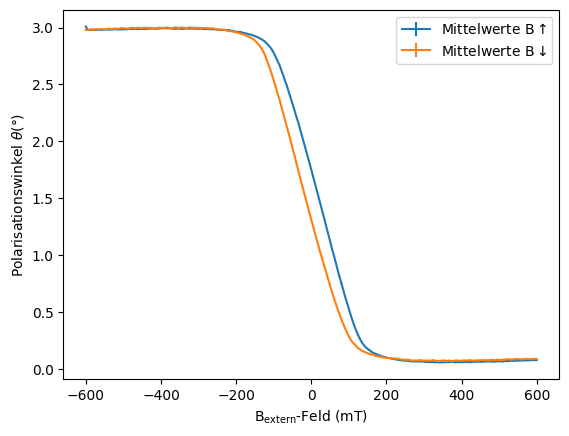

In [6]:
newfluxcalc(field1, voltage1,std1,direction1,loop1, polangle1, diodevoltage1, diodestd1, 5,80,"farad1.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.96736976276036 60


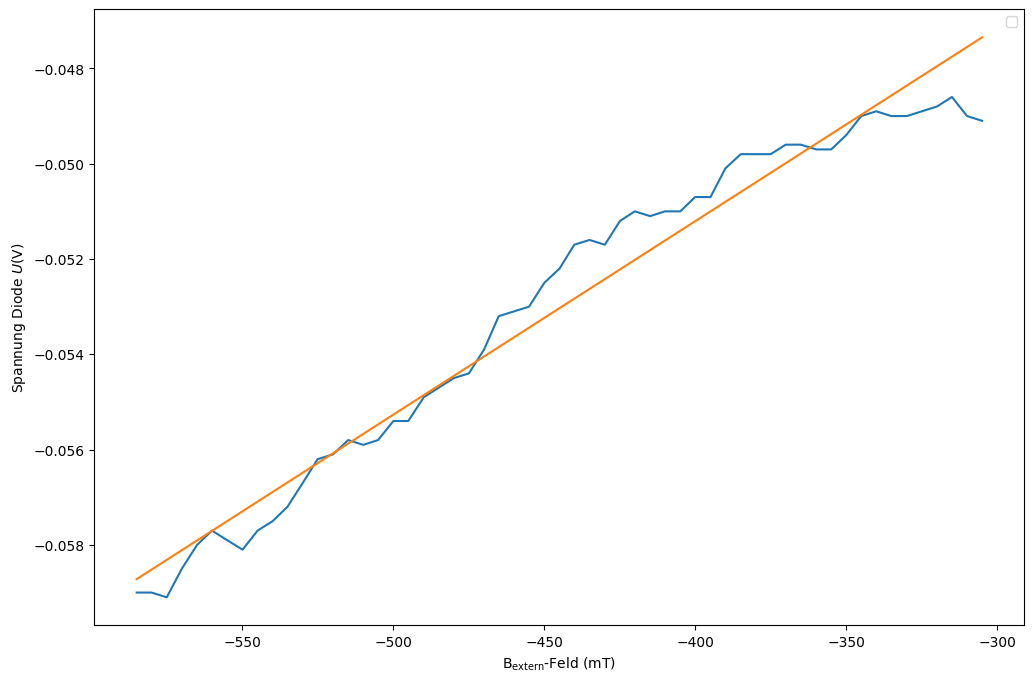

In [7]:
calibratelinearfit(fieldtwo,voltage2,std2, 3, 60)

Rotation je Mikrometer 5.802964287334031 Winkeldrehung 0.7717942502154261


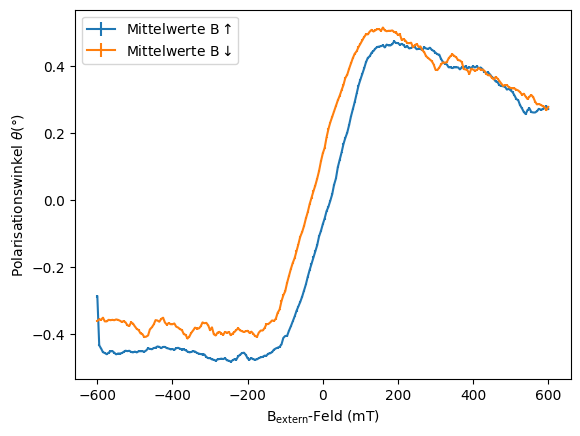

In [8]:
newfluxcalc(fieldtwo,voltage2, std2, direction2, loop2, polangle2, diodevoltage2, diodestd2, 3, 60,"kerr1.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.41468286403581667 80


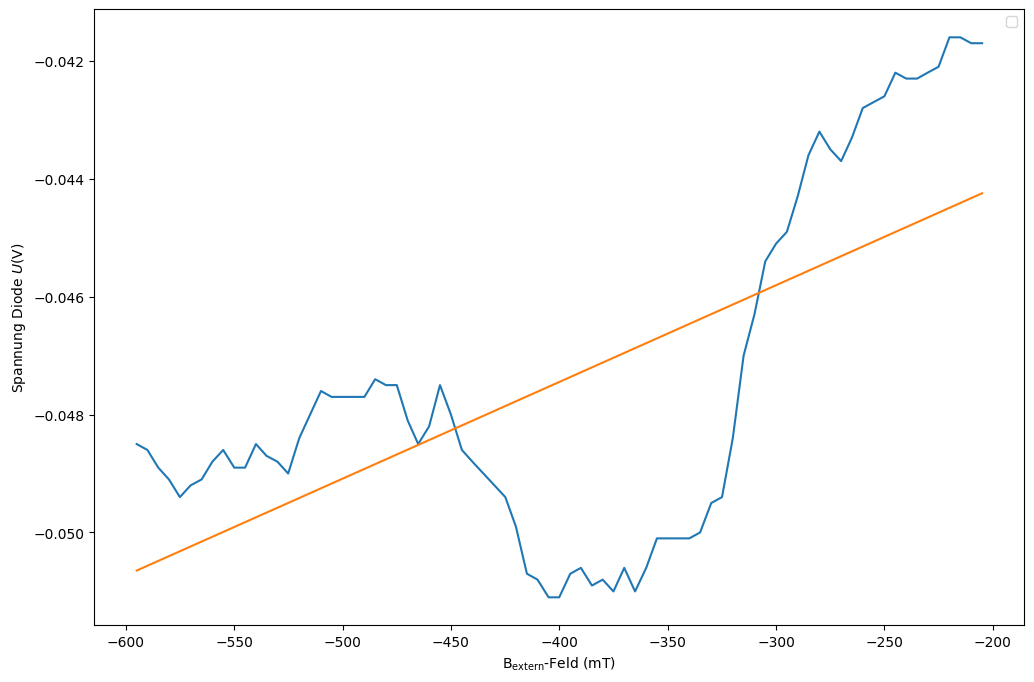

In [9]:
calibratelinearfit(field3, voltage3, std3,1,80)

Rotation je Mikrometer 7.761150999536505 Winkeldrehung 1.0322330829383553


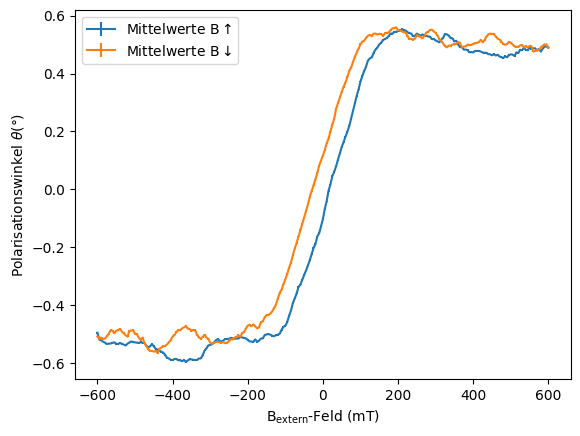

In [10]:
newfluxcalc(field3,voltage3, std3, direction3, loop3, polangle2, diodevoltage2, diodestd2, 1, 80,"kerr2.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8383907584211044 10


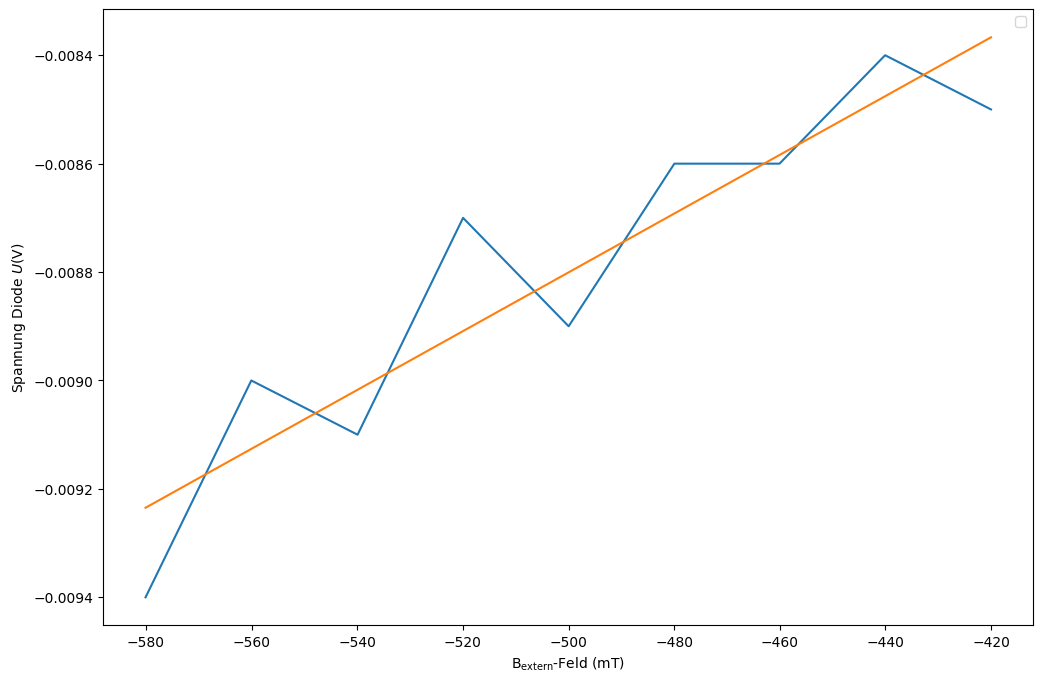

In [11]:
calibratelinearfit(field4,voltage4,std4,1,10)

Rotation je Mikrometer 2.9606060347832845 Winkeldrehung 0.39376060262617685


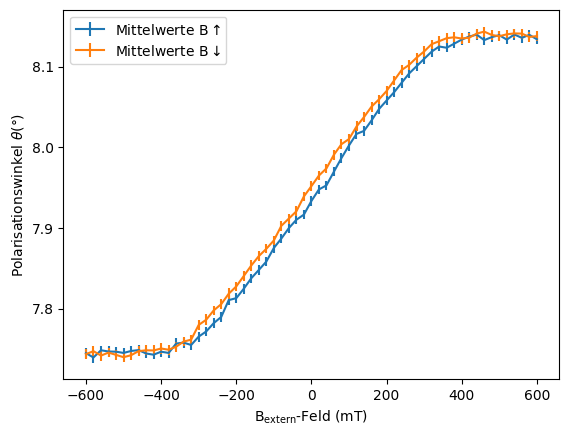

In [12]:
newfluxcalc(field4,voltage4,std4,direction4,loop4, polangle3,diodevoltage3,diodestd3,1,10,"faradaynickel.pdf")

In [23]:
def getcoer(field,voltage,std,direction,loop,n,k,fname):
    """Versuch das Koerzitivfeld berechnen zu lassen"""

    #Linearen Fit rausrechnen, mit den manuell bestimmten Werten
    reg = linear_model.LinearRegression()
    xres = field[n:k].reshape(-1,1)
    reg.fit(xres,voltage[n:k],sample_weight=1/std[n:k])
    m = reg.coef_
    b = reg.intercept_
    newy = voltage-(m*field+b)

    #Werte um die x-Achse mitteln ohne den ersten fehlerhaften Wert zu betrachten
    midvalue = np.mean(newy[n:]) 
    newval = newy-midvalue
    
    select_up = direction > 0
    select_down = direction <= 0 
    field_up_1 = field[(select_up) & (loop == 1)]
    field_down_1 = field[(select_down) & (loop == 1)]
    voltage_up_1 = newval[(select_up) & (loop == 1)]
    voltage_down_1 = newval[(select_down) & (loop == 1)]
    std_up_1 = std[(select_up) & (loop == 1)]
    std_down_1 = std[(select_down) & (loop == 1)]

    field_up_2 = field[(select_up) & (loop == 2)]
    field_down_2 = field[(select_down) & (loop == 2)]
    voltage_up_2 = newval[(select_up) & (loop == 2)]
    voltage_down_2 = newval[(select_down) & (loop == 2)]
    std_up_2 = std[(select_up) & (loop == 2)]
    std_down_2 = std[(select_down) & (loop == 2)]

    #Bei 2 Loops Werte mitteln
    if (len(field_up_1)==len(field_up_2)):
        field_up_mean = (field_up_1+field_up_2)/2
        field_down_mean = (field_down_1+field_down_2)/2
        voltage_up_mean = (voltage_up_1+voltage_up_2)/2
        voltage_down_mean = (voltage_down_1+voltage_down_2)/2
        yerrup = ((std_up_1)+(std_up_2))/2/10
        yerrdown = ((std_down_1)+(std_down_2))/2/10
    else:
        field_up_mean = (field_up_1)
        field_down_mean = field_down_1
        voltage_up_mean = voltage_up_1
        voltage_down_mean = voltage_down_1
        yerrup= std_up_1/10
        yerrdown = std_down_1/10

    #nullstellen finden
    i = np.argmin(np.fabs(voltage_up_1)) # nächsten Punkt zur Nullstelle finden
    x, y = field_up_1[i-3:i+4], voltage_up_1[i-3:i+4]
    x_rootleft = interpolate.interp1d(y, x, kind='linear')(0)

    k = np.argmin(np.fabs(voltage_down_1)) # Nächsten Punkt zur Nullstelle finden
    x1, y1 = field_down_1[k-3:k+4], voltage_down_1[k-3:k+4]
    x_rootright = interpolate.interp1d(y1, x1, kind='linear')(0)

    #Mitteln der Nullstellen (Berechneung des Offsets) -> Implementierung des Offsets
    rootdelta = np.abs((np.absolute(x_rootleft)-np.absolute(x_rootright)))/2
    if np.absolute(x_rootleft) < np.absolute(x_rootright):
        field_up_mean = field_up_mean + rootdelta
        field_down_mean = field_down_mean + rootdelta
        x_rootleft = x_rootleft + rootdelta
        x_rootright = x_rootright + rootdelta
    else: 
        field_up_mean = field_up_mean - rootdelta
        field_down_mean = field_down_mean - rootdelta
        x_rootleft = x_rootleft - rootdelta
        x_rootright = x_rootright - rootdelta


    xax = np.zeros(shape=len(field_up_1))

    plt.figure()
    plt.plot(field_up_1,xax, label = "x-axis")
    
    plt.errorbar(field_up_mean,voltage_up_mean, yerr = yerrup, label = r"Mittelwerte B$\uparrow$")
    plt.errorbar(field_down_mean,voltage_down_mean, yerr = yerrdown, label = r"Mittelwerte B$\downarrow$")
    plt.legend(loc = 0)
    plt.axis([-50,50,-0.025,0.025])
    plt.xlabel(r"B$_\mathrm{extern}$-Feld (mT)")
    plt.ylabel(r"Spannung Diode U(V)")
    plt.grid(True)
    plt.savefig(fname) 

    print("Nullstelle 1:",np.absolute(x_rootleft),"Nullstelle 2:",np.absolute(x_rootright),"Offset:",rootdelta)

Nullstelle 1: 17.90527193735541 Nullstelle 2: 17.90527193735541 Offset: 0.5064145789382586


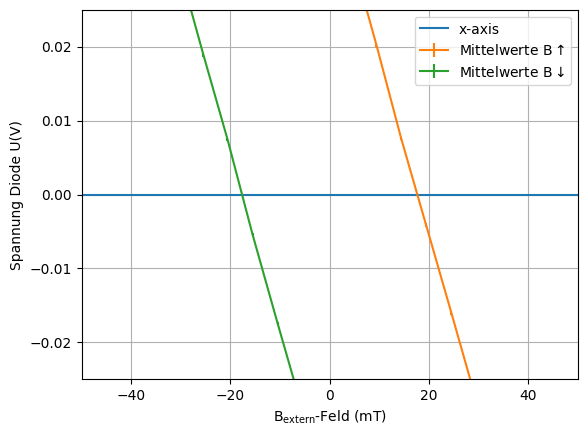

In [24]:
getcoer(field1, voltage1,std1,direction1,loop1, 5,80,"corecfarad.pdf")

Nullstelle 1: 26.139141958516397 Nullstelle 2: 26.139141958516397 Offset: 5.545432146140238


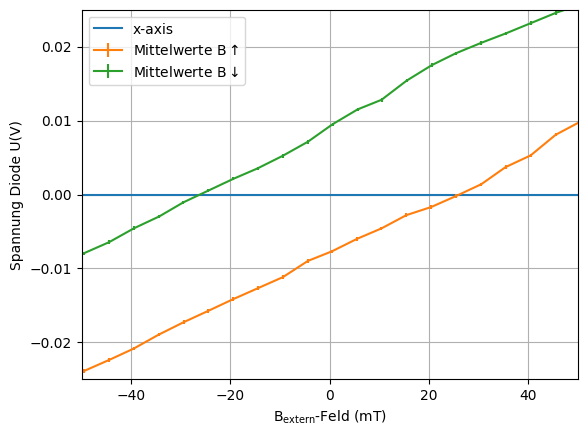

In [15]:
getcoer(fieldtwo,voltage2, std2, direction2, loop2, 3, 60,"coerkerr1.pdf")

Nullstelle 1: 22.18934745281465 Nullstelle 2: 22.18934745281465 Offset: 6.148194537980997


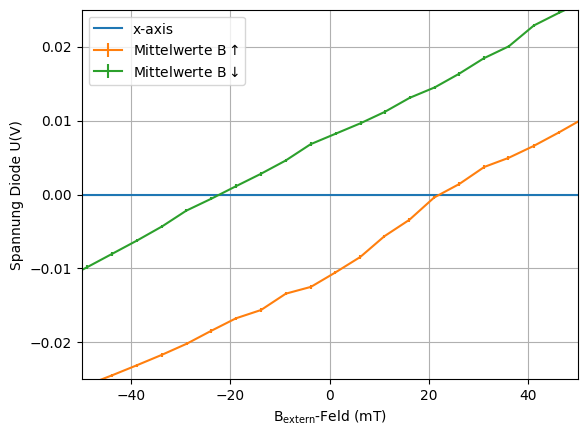

In [16]:
getcoer(field3,voltage3, std3, direction3, loop3, 1, 80,"corckerr2.pdf")

Nullstelle 1: 16.38648530994393 Nullstelle 2: 16.38648530994393 Offset: 0.15111201756035975


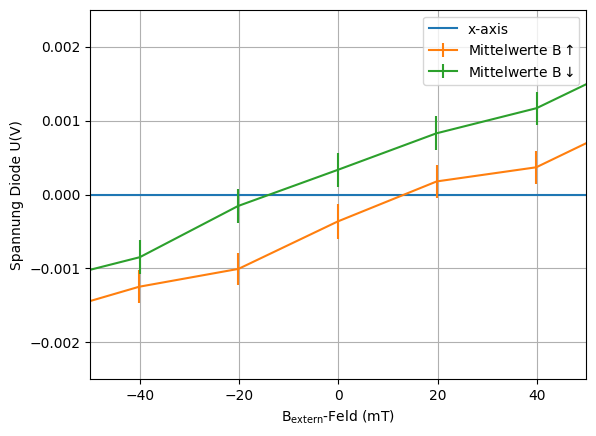

In [21]:
getcoer(field4,voltage4, std4, direction4, loop4, 1, 10,"coercnickel.pdf")

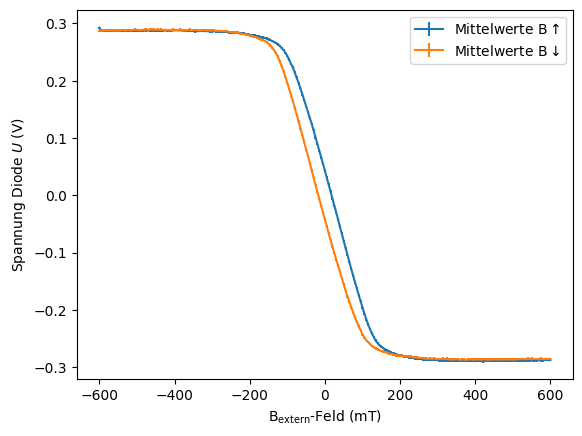

In [121]:
#Der Blockteil wurde nur zur Darstellung im Bericht verwendet, um Schritt für Schritt obiges Programm zu zeigen

select_up = direction1 > 0
select_down = direction1 <= 0

#Neue Variable, damit ich die hier zu exemplarischen Zwecken überschreiben kann.
exvoltage1 = voltage1
diodevoltage = diodevoltage1
polangle = polangle1
diodestd = diodestd1

# reg = linear_model.LinearRegression()
xres = field1[1:60].reshape(-1,1)
reg.fit(xres,exvoltage1[1:60], sample_weight=1/std1[1:60])
m = reg.coef_
b = reg.intercept_
rscore = reg.score(xres, exvoltage1[1:60])


exvoltage1 = exvoltage1 - (m*field1+b)  


#mittelung
midvalue = np.mean(exvoltage1[1:])
exvoltage1 = exvoltage1-midvalue


#Kalibrationskurve berechnen und Umrechnung V->°
# reg1 = linear_model.LinearRegression()
# calib = diodevoltage.reshape(-1,1)
# reg1.fit(calib,polangle,sample_weight=1/diodestd)
# m1 = reg1.coef_
# b1 = reg1.intercept_
# exvoltage1 = m1*exvoltage1+b1


field_up_1 = field1[(select_up) & (loop1 == 1)]
field_down_1 = field1[(select_down) & (loop1 == 1)]
voltage_up_1 = exvoltage1[(select_up) & (loop1 == 1)]
voltage_down_1 = exvoltage1[(select_down) & (loop1 == 1)]
std_up_1 = std1[(select_up) & (loop1 == 1)]
std_down_1 = std1[(select_down) & (loop1 == 1)]

field_up_2 = field1[(select_up) & (loop1 == 2)]
field_down_2 = field1[(select_down) & (loop1 == 2)]
voltage_up_2 = exvoltage1[(select_up) & (loop1 == 2)]
voltage_down_2 = exvoltage1[(select_down) & (loop1 == 2)]
std_up_2 = std1[(select_up) & (loop1 == 2)]
std_down_2 = std1[(select_down) & (loop1 == 2)]

#Bei 2 Loops Werte mitteln
if (len(field_up_1)==len(field_up_2)):
    field_up_mean = (field_up_1+field_up_2)/2
    field_down_mean = (field_down_1+field_down_2)/2
    voltage_up_mean = (voltage_up_1+voltage_up_2)/2
    voltage_down_mean = (voltage_down_1+voltage_down_2)/2
    yerrup = (std_up_1+std_up_2)/2
    yerrdown = (std_down_1+std_down_2)/2
else:
    field_up_mean = (field_up_1)
    field_down_mean = field_down_1
    voltage_up_mean = voltage_up_1
    voltage_down_mean = voltage_down_1
    yerrup= std_up_1
    yerrdown = std_down_1


plt.figure()

#plt.plot(field1, m*field1+b,label="linear fit")

plt.errorbar(field_up_mean,voltage_up_mean, yerr = yerrup, label = r"Mittelwerte B$\uparrow$")
plt.errorbar(field_down_mean,voltage_down_mean, yerr = yerrdown, label = r"Mittelwerte B$\downarrow$")
#plt.errorbar(field_up_2,voltage_up_2, yerr = m1*std_up_2, label = "loop 2 up")
#plt.errorbar(field_down_2,voltage_down_2, yerr = m1*std_down_2, label = "loop 2 down")
plt.legend(loc = 0)
plt.xlabel(r"B$_\mathrm{extern}$-Feld (mT)")
#plt.ylabel(r"Polarisationswinkel $\theta(°)$")
plt.ylabel(r"Spannung Diode $U$ (V)") 
plt.savefig('plot4.pdf')  

In [34]:
def plotlinearfit(diodevoltage,polangle,diodestd,fname):
    reg1 = linear_model.LinearRegression()
    calib = diodevoltage.reshape(-1,1)
    reg1.fit(calib,polangle,sample_weight=1/diodestd)
    m1 = reg1.coef_
    b1 = reg1.intercept_
    plt.scatter(diodevoltage,polangle,label="Kalibrationswerte",color="red")
    plt.plot(diodevoltage,m1*diodevoltage+b1,label="Linearer Fit")
    plt.legend(loc=0)
    plt.xlabel("Diode Spannung U(V)")
    plt.ylabel(r"Polarisationswinkel $\theta$(°)")
    plt.savefig(fname)

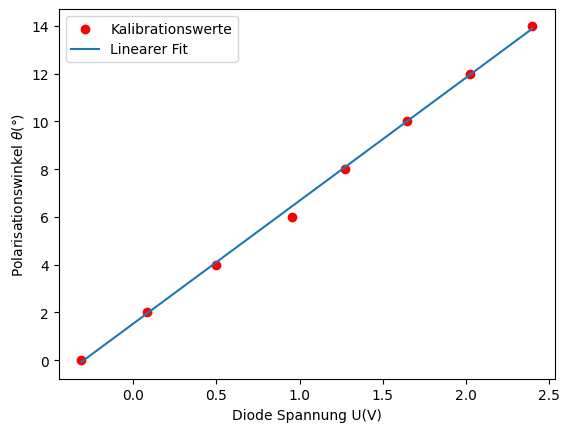

In [35]:
plotlinearfit(diodevoltage1,polangle1,diodestd1,"calibrationfit.pdf")